In [1]:
import pandas as pd
from pathlib import Path
# import reframed
# from reframed import fluxes2escher
import cobra
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import hdbscan
import seaborn as sns

# Three tasks to do to choose gene knockouts
1. Do all gene knockouts using momentiJO1366 and se which set of pFBA fluxes that are least correlated to wt
2. Do all gene knockouts using momentiJO1366 and se which which set of shadow prices that are least correlated to wt
3. Use the data from Uwe Sauer's paper https://doi.org/10.15252%2Fmsb.20167150 to check that the identified gienes actually has an impact on metabolite levels


## 1 and 2

In [2]:
# Load ecoli model
# model = reframed.load_cbmodel('../models/e_coli/momentiJO1366.xml')
# model = cobra.io.read_sbml_model('../models/e_coli/iJO1366.xml')
model = cobra.io.read_sbml_model('../models/e_coli/momentiJO1366.xml')
# model = cobra.io.read_sbml_model('../models/e_coli/iJR904.xml')
# model_ez.solver = 'gurobi'
model.solver = 'gurobi'
model.genes.get_by_id('b4301').knock_out() #This seems to be wrongly annotated rpe homolog

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-19


In [3]:
model.reactions.EX_glc__D_e.lower_bound = 0
model.reactions.EX_gal_e.lower_bound = -10

In [31]:
modeli = cobra.io.read_sbml_model('../models/e_coli/iJO1366.xml')
modeli.solver = 'gurobi'

In [5]:
# g = modeli.genes[0]

In [6]:
genes = [g.id for g in model.genes]
essential_genes = []
pfba_sol_wt = cobra.flux_analysis.pfba(model)
sol_wt = model.optimize()
wt_growth = sol_wt.objective_value
for gene in genes:
    with model:
        g = model.genes.get_by_id(gene)
        g.knock_out()
        sol = model.slim_optimize()
        if sol < wt_growth*0.1:
            essential_genes.append(gene)
    

In [7]:
solution = model.optimize()
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
prot_pool,ER_pool_TG_,0.095,0,0.00%
ca2_e,EX_ca2_e,0.001251,0,0.00%
cl_e,EX_cl_e,0.001251,0,0.00%
cobalt2_e,EX_cobalt2_e,6.011E-06,0,0.00%
cu2_e,EX_cu2_e,0.0001705,0,0.00%
fe2_e,EX_fe2_e,0.003862,0,0.00%
gal_e,EX_gal_e,2.708,6,100.00%
k_e,EX_k_e,0.04693,0,0.00%
mg2_e,EX_mg2_e,0.002086,0,0.00%
mn2_e,EX_mn2_e,0.0001661,0,0.00%


In [8]:
print(solution.fluxes['G6PDH2r_TG_forward'])
with model:
    model.genes.get_by_id('b1852').knock_out()
    sol = model.optimize()
    print(sol.fluxes['G6PDH2r_TG_forward'])
    print(st.spearmanr(solution.fluxes, sol.fluxes))
    


1.1769757487700292
0.0
SignificanceResult(statistic=0.978262368132672, pvalue=0.0)


In [9]:
non_essential_genes = [g for g in genes if not g in essential_genes]

In [10]:
data = []
fluxes_dict = {}
shadow_price_dict = {}
fluxes_dict['WT'] = sol_wt.fluxes
for gene in non_essential_genes:
    with model:
        model.genes.get_by_id(gene).knock_out()
        sol = model.optimize()
        try:
            pfba_sol = cobra.flux_analysis.pfba(model)
        except:
            continue

        # Correlations between fluxes
        flux_pcorr, flux_ppval  = st.pearsonr(pfba_sol.fluxes, pfba_sol_wt.fluxes)
        flux_scorr, flux_spval  = st.spearmanr(pfba_sol.fluxes, pfba_sol_wt.fluxes)

        # Correlations between shadow prices
        sp_pcorr, sp_ppval  = st.pearsonr(pfba_sol.shadow_prices, pfba_sol_wt.shadow_prices)
        sp_scorr, sp_spval  = st.spearmanr(pfba_sol.shadow_prices, pfba_sol_wt.shadow_prices)
        data.append([gene, sol.objective_value, flux_pcorr, flux_ppval, flux_scorr, flux_spval, sp_pcorr, sp_ppval, sp_scorr, sp_spval])
        fluxes_dict[gene] = pfba_sol.fluxes
        shadow_price_dict[gene] = sol.shadow_prices

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/Users/ssulheim/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [11]:
shadow_price_dict['WT'] = sol_wt.shadow_prices

In [12]:
df = pd.DataFrame(data, columns=['Gene','Growth rate', 'Flux pearson correlation', 'Flux pearson p-value', 'Flux spearman correlation', 'Flux spearman p-value',
                                        'Shadow price pearson correlation', 'Shadow price pearson p-value', 'Shadow price spearman correlation', 'Shadow price spearman p-value'])

In [32]:
gene_name_dict = {g.id:g.name for g in modeli.genes}
gene_name_dict['WT'] = 'Wild-type'

In [33]:
df['Gene name'] = df.Gene.map(gene_name_dict)

In [34]:
df.loc[df['Gene name'] == 'zwf',:]

,Gene,Growth rate,Flux pearson correlation,Flux pearson p-value,Flux spearman correlation,Flux spearman p-value,Shadow price pearson correlation,Shadow price pearson p-value,Shadow price spearman correlation,Shadow price spearman p-value,Gene name
535,b1852,0.239614,0.995422,0.0,0.9805,0.0,0.657712,2.975918e-224,0.892461,0.0,zwf


In [35]:
df['Normalized growth rate'] = df['Growth rate']/wt_growth

In [36]:
df.sort_values('Flux pearson correlation').head(20)

,Gene,Growth rate,Flux pearson correlation,Flux pearson p-value,Flux spearman correlation,Flux spearman p-value,Shadow price pearson correlation,Shadow price pearson p-value,Shadow price spearman correlation,Shadow price spearman p-value,Gene name,Normalized growth rate
347,b0431,0.208834,0.885469,0.0,0.967489,0.0,0.867850,0.000000e+00,0.896118,0.0,cyoB,0.868588
346,b0429,0.208834,0.885469,0.0,0.967489,0.0,0.867850,0.000000e+00,0.896118,0.0,cyoD,0.868588
345,b0430,0.208834,0.885469,0.0,0.967489,0.0,0.867850,0.000000e+00,0.896118,0.0,cyoC,0.868588
344,b0432,0.208834,0.885469,0.0,0.967489,0.0,0.867850,0.000000e+00,0.896118,0.0,cyoA,0.868588
828,b2279,0.230747,0.907207,0.0,0.963374,0.0,0.895662,0.000000e+00,0.918940,0.0,nuoK,0.959732
818,b2284,0.230747,0.907207,0.0,0.963374,0.0,0.895662,0.000000e+00,0.918940,0.0,nuoF,0.959732
819,b2288,0.230747,0.907207,0.0,0.963374,0.0,0.895662,0.000000e+00,0.918940,0.0,nuoA,0.959732
820,b2280,0.230747,0.907207,0.0,0.963374,0.0,0.895662,0.000000e+00,0.918940,0.0,nuoJ,0.959732
821,b2282,0.230747,0.907207,0.0,0.963374,0.0,0.895662,0.000000e+00,0.918940,0.0,nuoH,0.959732
822,b2277,0.230747,0.907207,0.0,0.963374,0.0,0.895662,0.000000e+00,0.918940,0.0,nuoM,0.959732


In [37]:
# norm=plt.Normalize(, df['Normalized growth rate'].max())

Text(0.5, 0, 'Flux pearson correlation')

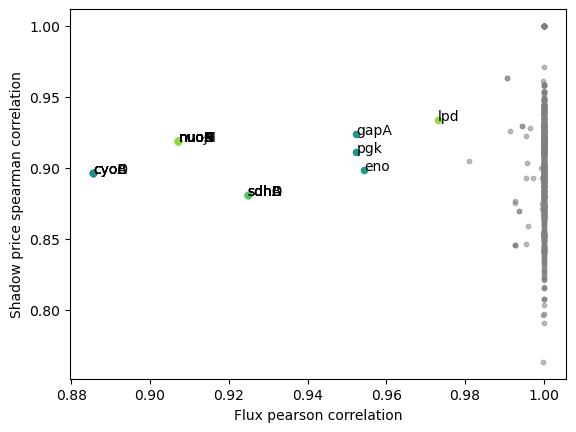

In [38]:
fig, ax = plt.subplots(1)
kind1 = 'pearson'
kind2 = 'spearman'

for i, row in df.iterrows():
    x = row[f'Flux {kind1} correlation']
    y = row[f'Shadow price {kind2} correlation']
    if (x < 0.98) and (y):
        ax.scatter(x,y, c = row['Normalized growth rate'], vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'Shadow price {kind2} correlation')
plt.xlabel(f'Flux {kind1} correlation')
# plt.ylim(0.5, 0.7)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

Text(0.5, 0, 'Flux pearson correlation')

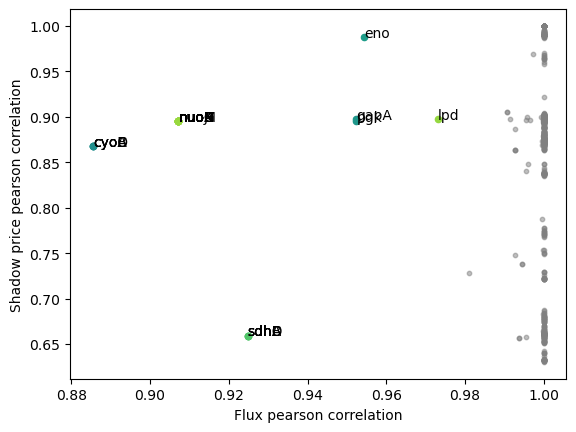

In [39]:
fig, ax = plt.subplots(1)
kind = 'pearson'
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    y = row[f'Shadow price {kind} correlation']
    if (x < 0.98) and (y):
        ax.scatter(x,y, c = row['Normalized growth rate'], vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'Shadow price {kind} correlation')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

Text(0.5, 0, 'Flux spearman correlation')

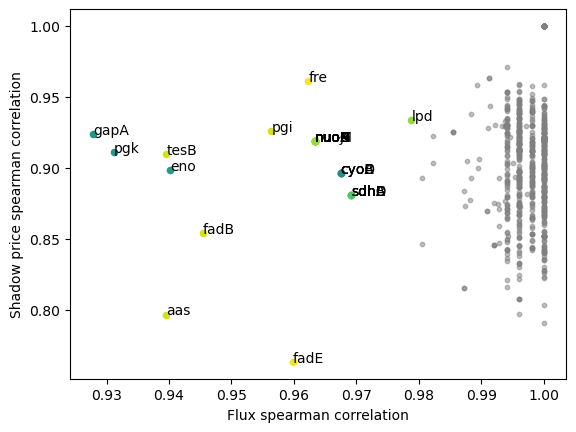

In [40]:
fig, ax = plt.subplots(1)
kind = 'spearman'
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    y = row[f'Shadow price {kind} correlation']
    if (x < 0.98) and (y):
        ax.scatter(x,y, c = row['Normalized growth rate'], vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'Shadow price {kind} correlation')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

# PCA

In [41]:
fluxes_df = pd.DataFrame(fluxes_dict)

In [42]:
nz_fluxes = fluxes_df.loc[~(fluxes_df==0).all(axis =1), :].T

In [43]:
Z_fluxes = (nz_fluxes - nz_fluxes.mean(axis=0))/(nz_fluxes.std(axis=0))

In [44]:
Z_fluxes = Z_fluxes.loc[:,nz_fluxes.std(axis=0)>1e-4]

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_87193/2129698872.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(t[:,0], t[:,1], cmap = 'jet')


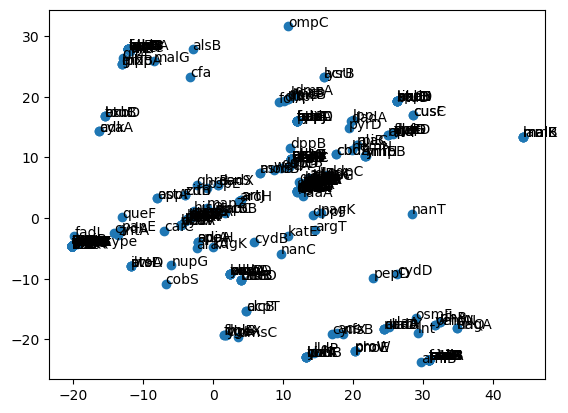

In [45]:
pca = PCA(n_components=2)
t = pca.fit_transform(Z_fluxes.T)
# clusterer = hdbscan.HDBSCAN()
# clusterer.fit(t)
fig, ax = plt.subplots(1)
ax.scatter(t[:,0], t[:,1], cmap = 'jet')
for i in range(len(t)):
    tx, ty = t[i, 0], t[i, 1]
    ax.annotate(gene_name_dict[Z_fluxes.index[i]], (tx, ty))
# print(len(np.unique(clustering.labels_)))

# Part 3

In [46]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/data/gene_KO_data')

In [47]:
neg_zscore = pd.read_csv(folder/'zscore_neg.tsv', sep = '\t', header=None)
pos_zscore = pd.read_csv(folder/'zscore_pos.tsv', sep = '\t', header=None)

In [48]:
zscores = pd.concat([neg_zscore, pos_zscore])

In [49]:
met_info = pd.read_excel(folder / 'metabolites.xlsx', sheet_name='Table EV1B')
met_info = met_info.iloc[1:,:4]

In [50]:
sample_info = pd.read_excel(folder / 'sample_id_zscore.xlsx', header = None)

In [51]:
zscores.columns = [x[0] for x in sample_info.values]

In [52]:
zscores

,aaeA,aaeB,aaeR,aaeX,aas,aat,abgA,abgB,abgR,abgT,...,zntR,znuA,znuB,znuC,zraP,zraR,zraS,zupT,zur,zwf
0,-0.4309,-1.8696,1.3402,0.2608,1.1950,-1.7969,-0.3466,0.8234,1.2770,0.5425,...,-1.0648,-0.2527,-0.8495,0.3368,0.0593,-0.0979,-0.3053,-0.0034,1.0841,0.1159
1,-0.1195,1.1863,-0.8219,-0.5211,0.2000,-1.5457,0.1708,0.8783,-0.2916,0.1869,...,-1.9948,0.5919,-1.2940,1.2607,1.2293,-3.1056,-2.4780,0.6874,-0.0932,-1.4013
2,-0.6621,1.7171,1.0256,0.0221,-0.4579,0.0185,0.4809,1.4925,0.5046,1.5039,...,-0.0292,0.4508,-3.3792,-0.9583,1.9758,-0.6508,-1.5141,2.3613,-2.3623,-0.4001
3,0.9284,0.3849,2.0786,-0.8930,0.8433,1.0175,0.7412,2.3298,-1.5026,0.5465,...,-0.9706,-0.4438,1.6652,-0.3749,0.3902,-0.5611,0.6083,0.0866,1.0464,0.3279
4,-0.6906,0.7550,-0.5455,0.4659,0.5156,-0.4498,0.5548,-0.8948,2.7675,0.6735,...,-0.1305,0.4575,-0.4649,-0.3647,-0.6224,0.0854,1.9919,0.2752,0.6782,0.3230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4360,0.6590,0.5567,0.7849,-0.4692,-1.0463,0.4669,0.5400,-0.6147,-0.5576,0.2206,...,-0.8172,-0.2027,-0.5120,0.7726,-0.7232,0.0849,1.9980,1.9671,-0.4920,1.3085
4361,-0.5588,0.2720,0.6939,0.4877,0.8092,0.2130,-0.3847,-0.3745,1.1807,-0.3879,...,0.8158,-0.4454,1.8465,-0.0894,0.8700,-1.1887,-1.6396,-1.5105,-0.5349,-0.2605
4362,-0.6122,0.0657,1.0083,0.9786,1.1222,-0.2939,0.5957,0.0391,2.2583,-0.0183,...,-3.1646,-0.2328,0.8116,0.0146,-0.2510,0.5481,-1.2467,0.9567,-0.7773,0.0695
4363,-1.5578,1.5634,-1.6051,0.4504,0.2041,-1.2855,0.7178,-0.6646,1.8836,0.3146,...,-2.6431,0.0096,-1.0767,0.4105,0.9191,-0.0470,-1.4584,-0.4606,-0.3933,-0.4982


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_87193/191682773.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(t[:,0], t[:,1], cmap = 'jet')


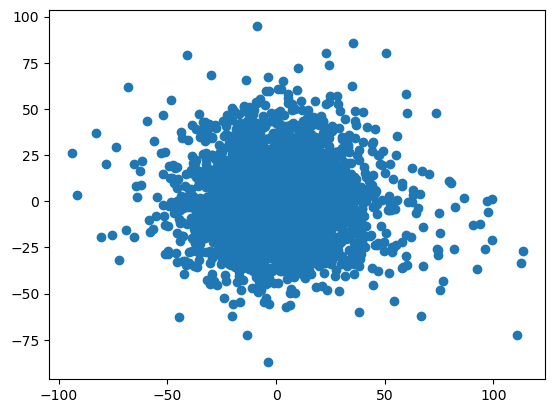

In [53]:
pca = PCA(n_components=2)
t = pca.fit_transform(zscores.T)
# clusterer = hdbscan.HDBSCAN()
# clusterer.fit(t)
fig, ax = plt.subplots(1)
ax.scatter(t[:,0], t[:,1], cmap = 'jet')
# for i in range(len(t)):
#     tx, ty = t[i, 0], t[i, 1]
#     ax.annotate(gene_name_dict[Z_fluxes.index[i]], (tx, ty))
# print(len(np.unique(clustering.labels_)))

In [54]:
n_changes = (zscores.abs() > 5).sum().sort_values(ascending = False) # This is the 0.1% most significant changes they use in the paper. 
n_changes_001 = (zscores.abs() > 3.291).sum().sort_values(ascending = False)
# Can also e.g. use 3.291, corresponding to a p+value of 0.001. See https://www.calculator.net/z-score-calculator.html?c2z=&c2p=&c2pg=&c2p0=&c2pin=&c2pout=0.001&calctype=converter&x=Calculate#converter for other values

In [55]:
n_changes['lacA']

2

In [56]:
n_changes.head(30)

rpmG    560
msrA    430
nuoA    410
glcB    354
talA    271
tap     244
bglA    231
yhbT    218
yafY    206
upp     206
cysH    200
purR    193
kdpD    187
rcsC    186
ybhP    184
uhpA    181
cpxR    181
uhpB    179
ybeX    176
rpoN    175
dkgA    162
yhdL    162
lomR    151
ybiW    150
cheY    136
pmbA    136
nuoN    135
gltA    135
dld     134
potH    132
dtype: int64

In [57]:
bc = np.bincount(n_changes)

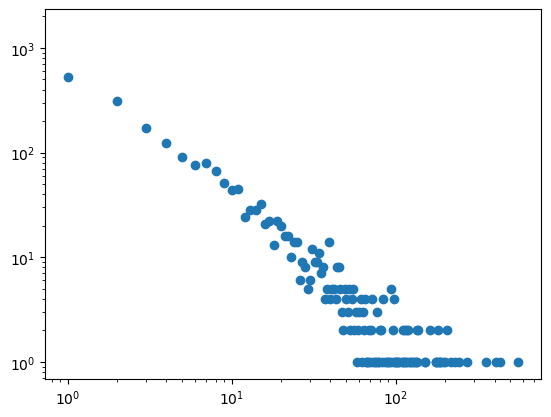

In [58]:
plt.scatter(np.arange(len(bc)), bc)
plt.xscale('log')
plt.yscale('log')

(array([3.513e+03, 1.700e+02, 5.000e+01, 3.000e+01, 2.000e+01, 4.000e+00,
        9.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.,  28.,  56.,  84., 112., 140., 168., 196., 224., 252., 280.,
        308., 336., 364., 392., 420., 448., 476., 504., 532., 560.]),
 <BarContainer object of 20 artists>)

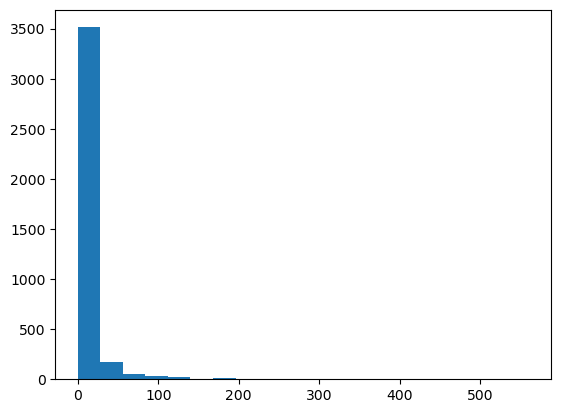

In [59]:
plt.hist(n_changes, bins = 20)

# Plot N changes in metabolite values vs correlation

In [60]:
# with model:
#     model.genes.get_by_id('b1136').knock_out()
#     print(model.optimize())

cyoC 0.9674890766971983 45
cyoD 0.9674890766971983 61
nuoF 0.9633744767467105 65
nuoA 0.9633744767467105 410
nuoJ 0.9633744767467105 98
nuoM 0.9633744767467105 94
nuoN 0.9633744767467105 135
nuoL 0.9633744767467105 88
pgi 0.9563721808011203 54
ppk 0.9894358112826555 31
serB 0.9883143486478658 93
rpe 0.9883355728298379 72
sufE 0.9873070867923684 39
sdhC 0.9692147797413982 31
sdhD 0.9692147797413982 46
tpiA 0.9877479089653435 90


(0.95, 1.0)

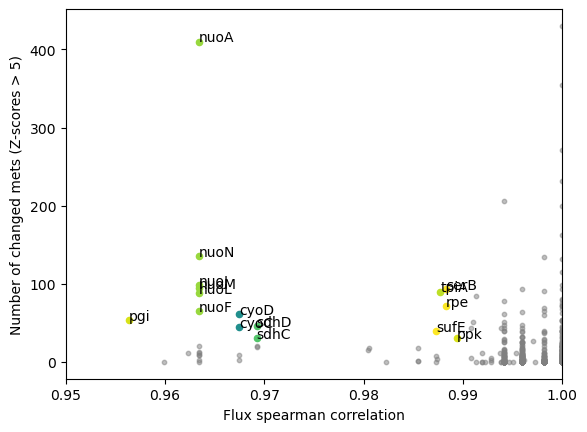

In [61]:
fig, ax = plt.subplots(1)
kind = 'spearman'
j = 0
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    else:
        j+=1
        # print(i, row["Gene name"], y)
    if ((x < 0.99) and (y> 30)):
        ax.scatter(x,y, c = row['Normalized growth rate'],
                   vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
        print(row['Gene name'], x, y)
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'Number of changed mets (Z-scores > 5)')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
plt.xlim(0.95, 1)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

cyoD 0.9674890766971983 61
nuoF 0.9633744767467105 65
nuoA 0.9633744767467105 410
nuoJ 0.9633744767467105 98
nuoM 0.9633744767467105 94
nuoN 0.9633744767467105 135
nuoL 0.9633744767467105 88
pgi 0.9563721808011203 54
serB 0.9883143486478658 93
rpe 0.9883355728298379 72
tpiA 0.9877479089653435 90


Text(0.5, 0, 'Flux spearman correlation')

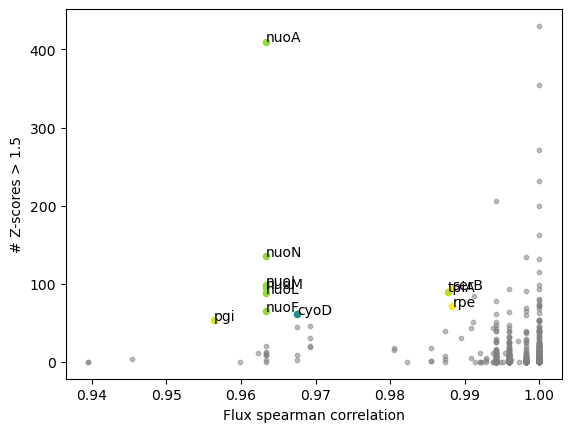

In [62]:
fig, ax = plt.subplots(1)
kind = 'spearman'
j = 0
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    else:
        j+=1
        # print(i, row["Gene name"], y)
    if ((x < 0.99) and (y> 50)) or (y > 480):
        ax.scatter(x,y, c = row['Normalized growth rate'],
                   vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
        print(row['Gene name'], x, y)
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'# Z-scores > 1.5')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
# plt.xlim(0.9, 1)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

# Notes
- glcB: Anaplerotic reaction in TCA from glyoxylate to malate
- dld: lactate to pyruvate
- talA: PPP (interesting!)
- nuoA: Electron transport chain
- fadB: degradation of fatty acids via the β-oxidation cycle
- cyoD: cytochrome electron transport chain
- ackA: acetate to acetyl-phosphate,  propionyl-CoA metabolism
- pfkA, 6-phosphofructokinase I;, glycolysis
- tktB: transketolase, PPP
- rpmG: ribosomal subunit
- msrA: methionine sulfoxide reductases, repairs oxidized methionine residues on proteins
- tap: chemotaxis
- purR: Regulatory gene, PurR dimer controls several genes involved in purine nucleotide biosynthesis and its own synthesis
- uhpA: UhpBA two-component signal transduction system (TCS) forms part of the E. coli Uhp system which is responsible for sensing and transport of the metabolic intermediate, glucose-6-phosphate.
- pldA: Outer membrane somethin
- glk: GLucose to glucose 6-phosphate
- pgi:
- sdhB: succinate:quinone oxidoreductase
- tpiA: D-glyceraldehyde 3-phosphate ⇄ glycerone phosphate
- frdA: Fumarate reductase, anaerobic respiration
- adhE: aldehyde/alcohol dehydrogenase AdhE
- dkgA: methylglyoxal reductase DkgA
# Other comments:
- eno: Essential
- rcsC: Regulator/signalling
- cysH: sulfate reduction, 3'-Phospho-adenylylsulfate reductase (CysH) is involved in the assimilation of sulfate and catalyzes the reduction of 3'-phospho-adenylylsulfate (PAPS) to sulfite and PAP. As a consequence of this and a subsequent reaction, the adenylate removed from the cell at the initiation of the cysteine biosynthetic pathway is returned as AMP
- ppc: Essential in MM according to ecocyc
- glyA: Essential


# Plot changes in shadow prices of measurable metabolites

In [63]:
#,'glcB',  'pfkA', 'tktB',, 'dld''talA',
# selected_genes = ['pgi',  'nuoA', 'fadB', 'cyoD', 'ackA', 'rpmG', 'msrA', 'pldA', 'glk', 'tpiA', 'sucB', 'sdhB', 'adhE', 'frdA', 'fumC', 'zwf', 'rpe', 'aceE', 'lacA']
selected_genes = ['nuoA', 'pgi', 'cyoD', 'tpiA', 'sucB', 'sdhB', 'zwf', 'rpe', 'aceE', 'lacA']#rpmG
selected_genes = sorted(selected_genes)
name_gene_dict = {name:gene for gene, name in gene_name_dict.items()}

In [64]:
selected_gene_ids = [name_gene_dict[x] for x in selected_genes if name_gene_dict.get(x)]

In [65]:
measureable_mets = ['ala__L','arg__L','asn__L','ala_B','citr__L','4abut','glu__L','gln__L','gly__L','his__L','hmcr','ile__L',
'Lkynr','leu__L','lys__L','met__L','orn__L','phe__L','Lpipecol','pro__L','ser__L','taur','thr__L','4hpro_LT','trp__L','tyr__L','val__L','accoa','cit','icit','akg','succoa','succ','mal__L','gccoa','acon_T','g6p','f6p','pep','pyr','lac__L']

In [66]:
selected_gene_ids += ['WT']

In [67]:
data = []
met_ids = [f'{x}_c' for x in measureable_mets if f'{x}_c' in shadow_price_dict['WT'].index]

for gene in selected_gene_ids:
    try:
        sp = shadow_price_dict[gene][met_ids].values
    except KeyError:
        print(gene)
        continue
    else:
        if sp is not None:
            data.append([gene, gene_name_dict[gene]]+list(sp))

In [68]:
sp_df = pd.DataFrame(data, columns = ['Gene', 'Gene name']+[x[:-2] for x in met_ids])
value_cols = [x[:-2] for x in met_ids]

In [69]:
Z_sp_df = (sp_df[value_cols] - sp_df[value_cols].mean(axis = 0))/sp_df[value_cols].std(axis = 0)
Z_sp_df['Gene name'] = sp_df['Gene name']

In [70]:
colors = sns.color_palette('tab20')

Text(0.5, 0, 'Z-score')

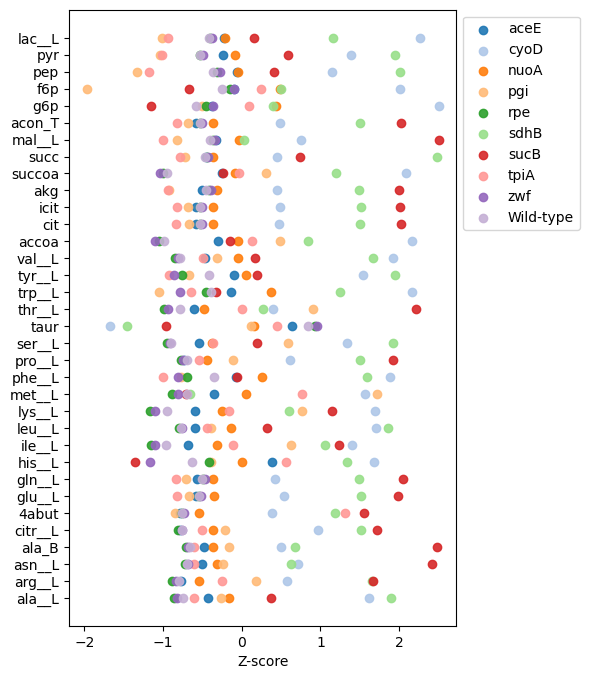

In [71]:
fig, ax = plt.subplots(1, figsize = (5,8))
x = np.arange(len(met_ids))
for i, row in Z_sp_df.iterrows():
    y = row[sp_df.columns[2:]]
    ax.scatter(x = y, y = x, label = row['Gene name'], color = colors[i], alpha = 0.9)
# plt.yscale('log')
# plt.xticks
plt.legend(bbox_to_anchor = (1, 1))
ax.set_yticks(x)
ax.set_yticklabels(value_cols)
plt.xlabel('Z-score')

aceE 84
cyoD 61
lacA 2
nuoA 410
pgi 54
rpe 72
sdhB 19
sucB 43
tpiA 90
zwf 15


Text(0.5, 0, 'Flux spearman correlation')

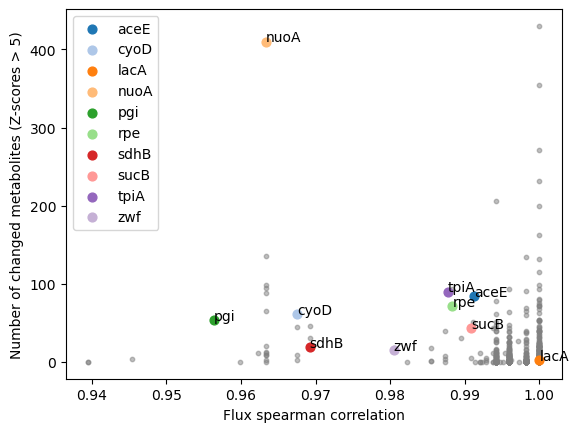

In [72]:
fig, ax = plt.subplots(1)
corr_kind = 'spearman'
data = 'Flux'

correlation_dict = df.set_index('Gene name')[f'{data} {corr_kind} correlation'].to_dict()


j = 0

for i, row in df.iterrows():
    x = row[f'{data} {corr_kind} correlation']
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
   
    
for i, gene in enumerate(selected_genes):
    y = n_changes[gene]
    if correlation_dict.get(gene):
        x = correlation_dict[gene]
    else:
        x = 1
    ax.scatter(x,y,color = colors[i], #row['Normalized growth rate'],
           s = 40, label = gene)
    ax.annotate(gene, (x, y))
    # print(row['Gene name'], x, y)
    print(gene, y)
plt.legend() 
plt.ylabel(f'Number of changed metabolites (Z-scores > 5)')
plt.xlabel(f'{data} {corr_kind} correlation')
# plt.ylim(0, 1200)

aceE 231
cyoD 267
lacA 5
nuoA 1028
pgi 360
rpe 261
sdhB 185
sucB 160
tpiA 295
zwf 101


Text(0.5, 0, 'Flux spearman correlation')

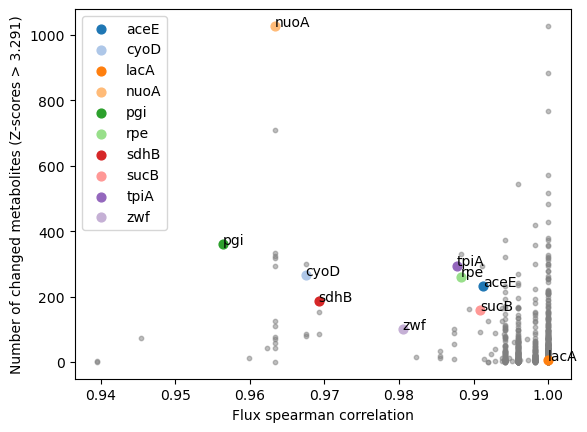

In [73]:
fig, ax = plt.subplots(1)
corr_kind = 'spearman'
data = 'Flux'
correlation_dict = df.set_index('Gene name')[f'{data} {corr_kind} correlation'].to_dict()

j = 0

for i, row in df.iterrows():
    x = row[f'{data} {corr_kind} correlation']
    try:
        y = n_changes_001[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
   
    
for i, gene in enumerate(selected_genes):
    y = n_changes_001[gene]
    if correlation_dict.get(gene):
        x = correlation_dict[gene]
    else:
        x = 1
    ax.scatter(x,y,color = colors[i], #row['Normalized growth rate'],
           s = 40, label = gene)
    ax.annotate(gene, (x, y))
    # print(row['Gene name'], x, y)
    print(gene, y)
plt.legend() 
plt.ylabel(f'Number of changed metabolites (Z-scores > 3.291)')
plt.xlabel(f'{data} {corr_kind} correlation')
# plt.ylim(0, 1200)

# Final selection

In [74]:
final_selection = ['nuoA', 'pgi', 'cyoD', 'tpiA', 'sucB', 'sdhB', 'rpmG', 'zwf', 'rpe', 'aceE', 'lacA']
for gene_name in final_selection:
    

SyntaxError: incomplete input (2829936433.py, line 3)

In [ ]:
#moment iJO1366
# raise ValueError

fig, ax = plt.subplots(1, figsize = (5,8))
x = np.arange(len(met_ids))
for i, row in Z_sp_df.iterrows():
    y = row[sp_df.columns[2:]]
    ax.scatter(x = y, y = x, label = row['Gene name'], color = colors[i], alpha = 0.9)
# plt.yscale('log')
# plt.xticks
plt.legend(bbox_to_anchor = (1, 1))
ax.set_yticks(x)
ax.set_yticklabels(value_cols)
plt.xlabel('Z-score')

In [ ]:
# iJO1366 galactose
fig, ax = plt.subplots(1, figsize = (5,8))
x = np.arange(len(met_ids))
for i, row in Z_sp_df.iterrows():
    y = row[sp_df.columns[2:]]
    ax.scatter(x = y, y = x, label = row['Gene name'], color = colors[i], alpha = 0.9)
# plt.yscale('log')
# plt.xticks
plt.legend(bbox_to_anchor = (1, 1))
ax.set_yticks(x)
ax.set_yticklabels(value_cols)
plt.xlabel('Shadow price (Z-score)')

In [ ]:
x = met_ids[0]
x in shadow_price_dict[gene].index

In [ ]:
shadow_price_dict[gene][met_ids].values